# The Power Spectrum of Data in a Simulation Box

In this notebook, we explore the functionality of the ``FFTPower`` algorithm, which can compute the 1D power spectrum $P(k)$, 2D power spectrum $P(k,\mu)$, and multipoles $P_\ell(k)$. The algorithm is suitable for use on data sets in periodic simulation boxes, as the power spectrum is computed via a single FFT of the density mesh. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [3]:
setup_logging()

## Initalizing a Log-normal Mock

We start by generating a mock catalog of biased objects ($b_1 = 2$ ) at a redshif $z=0.55$. We use the *Planck* 2015 cosmology and the Eisenstein-Hu linear power spectrum fitting formula. We generate the catalog in a box of side length $L = 1380 \ \mathrm{Mpc}/h$ with a constant number density $\bar{n} = 3 \times 10^{-3} \ h^{3} \mathrm{Mpc}^{-3}$.

In [4]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
b1 = 2.0

cat = LogNormalCatalog(Plin=Plin, nbar=3e-4, BoxSize=1380., Nmesh=256, bias=b1, seed=42)

We update the ``Position`` column to add redshift-space distortions along the ``z`` axis of the box using the ``VelocityOffset`` column.

In [5]:
# add RSD
line_of_sight = [0,0,1]
cat['RSDPosition'] = cat['Position'] + cat['VelocityOffset'] * line_of_sight

## Computing the 1D Power, $P(k)$

In this section, we compute and plot the 1D power spectrum $P(k)$ of the log-normal mock.  

We must first convert our ``CatalogSource`` object to a ``MeshSource``, by setting up the mesh and specifying which interpolation kernel we wish to use. Here, we use "TSC" interpolation, and specify via ``compensated=True`` that we wish to correct for the effects of the interpolation window in Fourier space.

In [6]:
# convert to a MeshSource, using TSC interpolation on 256^3 mesh
mesh = cat.to_mesh(window='tsc', Nmesh=256, compensated=True, position='RSDPosition')

We compute the 1D power spectrum by specifying ``mode`` as "1d". We also choose the desired linear ``k`` binning by specifying the bin spacing via ``dk`` and the minimum ``k`` value via ``kmin``. 

In [7]:
# compute the power, specifying desired linear k-binning
r = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)

[ 000010.90 ]   0: 10-30 20:44  CatalogMesh     INFO     painted 787121 out of 787121 objects to mesh


[ 000010.90 ]   0: 10-30 20:44  CatalogMesh     INFO     mean particles per cell is 0.0469161


[ 000010.91 ]   0: 10-30 20:44  CatalogMesh     INFO     sum is 787120 


[ 000010.91 ]   0: 10-30 20:44  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000011.25 ]   0: 10-30 20:44  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


The result is computed when initializing the ``FFTPower`` class and the power spectrum results are stored as a ``BinnedStatistic`` object as the ``power`` attribute. 

In [8]:
# the result is stored at "power" attribute
Pk = r.power
print(Pk)

<BinnedStatistic: dims: (k: 115), variables: ('k', 'power', 'modes')>


The ``coords`` attribute of the ``BinnedStatistic`` object specifies the coordinate grid for the binned result, which in this case, is just the center values of the ``k`` bins.  

By default, the power is computed up to the 1D [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency), which is defined as $k_\mathrm{Nyq} = \pi N_\mathrm{mesh} / L_\mathrm{box}$, which in this case is equal to $k_\mathrm{Nyq} = \pi \cdot 256 / 1380 = 0.5825 \ h \ \mathrm{Mpc}^{-1}$.

In [9]:
print(Pk.coords)

{'k': array([ 0.0125,  0.0175,  0.0225,  0.0275,  0.0325,  0.0375,  0.0425,
        0.0475,  0.0525,  0.0575,  0.0625,  0.0675,  0.0725,  0.0775,
        0.0825,  0.0875,  0.0925,  0.0975,  0.1025,  0.1075,  0.1125,
        0.1175,  0.1225,  0.1275,  0.1325,  0.1375,  0.1425,  0.1475,
        0.1525,  0.1575,  0.1625,  0.1675,  0.1725,  0.1775,  0.1825,
        0.1875,  0.1925,  0.1975,  0.2025,  0.2075,  0.2125,  0.2175,
        0.2225,  0.2275,  0.2325,  0.2375,  0.2425,  0.2475,  0.2525,
        0.2575,  0.2625,  0.2675,  0.2725,  0.2775,  0.2825,  0.2875,
        0.2925,  0.2975,  0.3025,  0.3075,  0.3125,  0.3175,  0.3225,
        0.3275,  0.3325,  0.3375,  0.3425,  0.3475,  0.3525,  0.3575,
        0.3625,  0.3675,  0.3725,  0.3775,  0.3825,  0.3875,  0.3925,
        0.3975,  0.4025,  0.4075,  0.4125,  0.4175,  0.4225,  0.4275,
        0.4325,  0.4375,  0.4425,  0.4475,  0.4525,  0.4575,  0.4625,
        0.4675,  0.4725,  0.4775,  0.4825,  0.4875,  0.4925,  0.4975,
        0.5025

The input parameters to the algorithm, as well as the meta-data computed during the calculation, are stored in the ``attrs`` dictionary attribute. A key attribute is the Poisson shot noise, stored as the "shotnoise" key.

In [10]:
# print out the meta-data
for k in Pk.attrs:
    print("%s = %s" %(k, str(Pk.attrs[k])))

Nmesh = [256 256 256]
BoxSize = [ 1380.  1380.  1380.]
dk = 0.005
kmin = 0.01
Lx = 1380.0
Ly = 1380.0
Lz = 1380.0
volume = 2628072000.0
mode = 1d
los = [0, 0, 1]
Nmu = 1
poles = []
N1 = 787121
N2 = 787121
shotnoise = 3338.84116927


Now, we plot the 1D power, first subtracting out the shot noise. Note that the power is complex, so we only plot the real part. 

(0.01, 0.6)

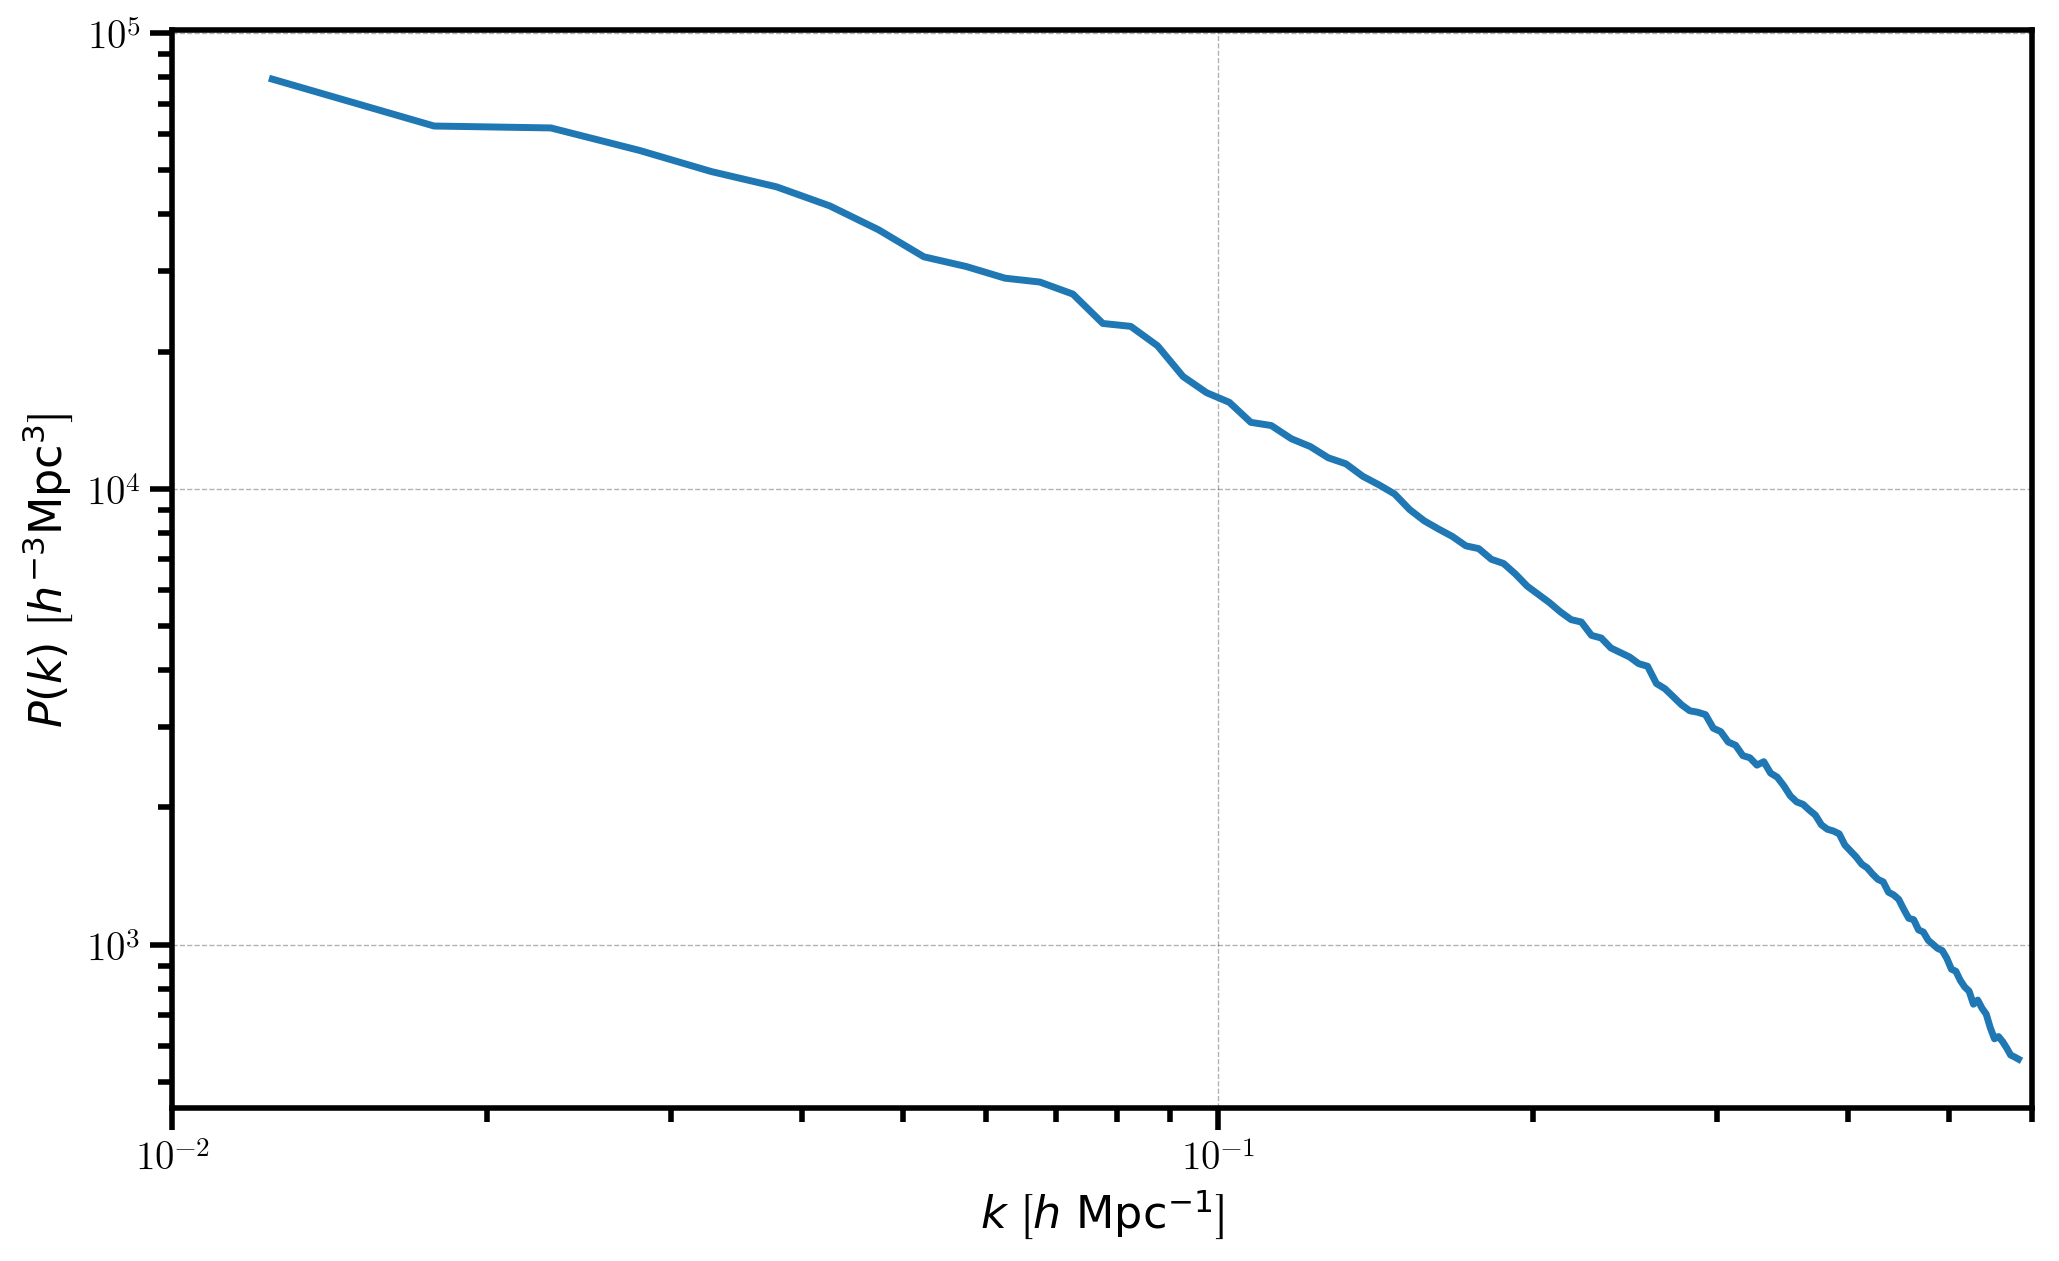

In [11]:
# print the shot noise subtracted P(k)
plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'])

# format the axes
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

## Computing the 2D Power, $P(k,\mu)$

In this section, we compute and plot the 2D power spectrum $P(k,\mu)$. For illustration, we compute results using a line-of-sight that is both parallel and perpendicular to the direction that we added redshift-space distortions.

Here, we compute $P(k,\mu)$ where $\mu$ is defined with respect to the ``z`` axis (``los=[0,0,1]``), using 5 $\mu$ bins ranging from $\mu=0$ to $\mu=1$.

In [12]:
# compute the 2D power
r = FFTPower(mesh, mode='2d', dk=0.005, kmin=0.01, Nmu=5, los=[0,0,1])
Pkmu = r.power
print(Pkmu)

[ 000014.28 ]   0: 10-30 20:44  CatalogMesh     INFO     painted 787121 out of 787121 objects to mesh


[ 000014.29 ]   0: 10-30 20:44  CatalogMesh     INFO     mean particles per cell is 0.0469161


[ 000014.29 ]   0: 10-30 20:44  CatalogMesh     INFO     sum is 787120 


[ 000014.29 ]   0: 10-30 20:44  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000014.71 ]   0: 10-30 20:44  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


<BinnedStatistic: dims: (k: 115, mu: 5), variables: ('k', 'mu', 'power', 'modes')>


The ``coords`` attribute of the result now gives the centers of both the ``k`` and ``mu`` bins. 

In [13]:
print(Pkmu.coords)

{'k': array([ 0.0125,  0.0175,  0.0225,  0.0275,  0.0325,  0.0375,  0.0425,
        0.0475,  0.0525,  0.0575,  0.0625,  0.0675,  0.0725,  0.0775,
        0.0825,  0.0875,  0.0925,  0.0975,  0.1025,  0.1075,  0.1125,
        0.1175,  0.1225,  0.1275,  0.1325,  0.1375,  0.1425,  0.1475,
        0.1525,  0.1575,  0.1625,  0.1675,  0.1725,  0.1775,  0.1825,
        0.1875,  0.1925,  0.1975,  0.2025,  0.2075,  0.2125,  0.2175,
        0.2225,  0.2275,  0.2325,  0.2375,  0.2425,  0.2475,  0.2525,
        0.2575,  0.2625,  0.2675,  0.2725,  0.2775,  0.2825,  0.2875,
        0.2925,  0.2975,  0.3025,  0.3075,  0.3125,  0.3175,  0.3225,
        0.3275,  0.3325,  0.3375,  0.3425,  0.3475,  0.3525,  0.3575,
        0.3625,  0.3675,  0.3725,  0.3775,  0.3825,  0.3875,  0.3925,
        0.3975,  0.4025,  0.4075,  0.4125,  0.4175,  0.4225,  0.4275,
        0.4325,  0.4375,  0.4425,  0.4475,  0.4525,  0.4575,  0.4625,
        0.4675,  0.4725,  0.4775,  0.4825,  0.4875,  0.4925,  0.4975,
        0.5025

We plot each the power for each of the 5 $\mu$ bins, and we see the effects of redshift-space distortions as a function of $\mu$.

(0.01, 0.6)

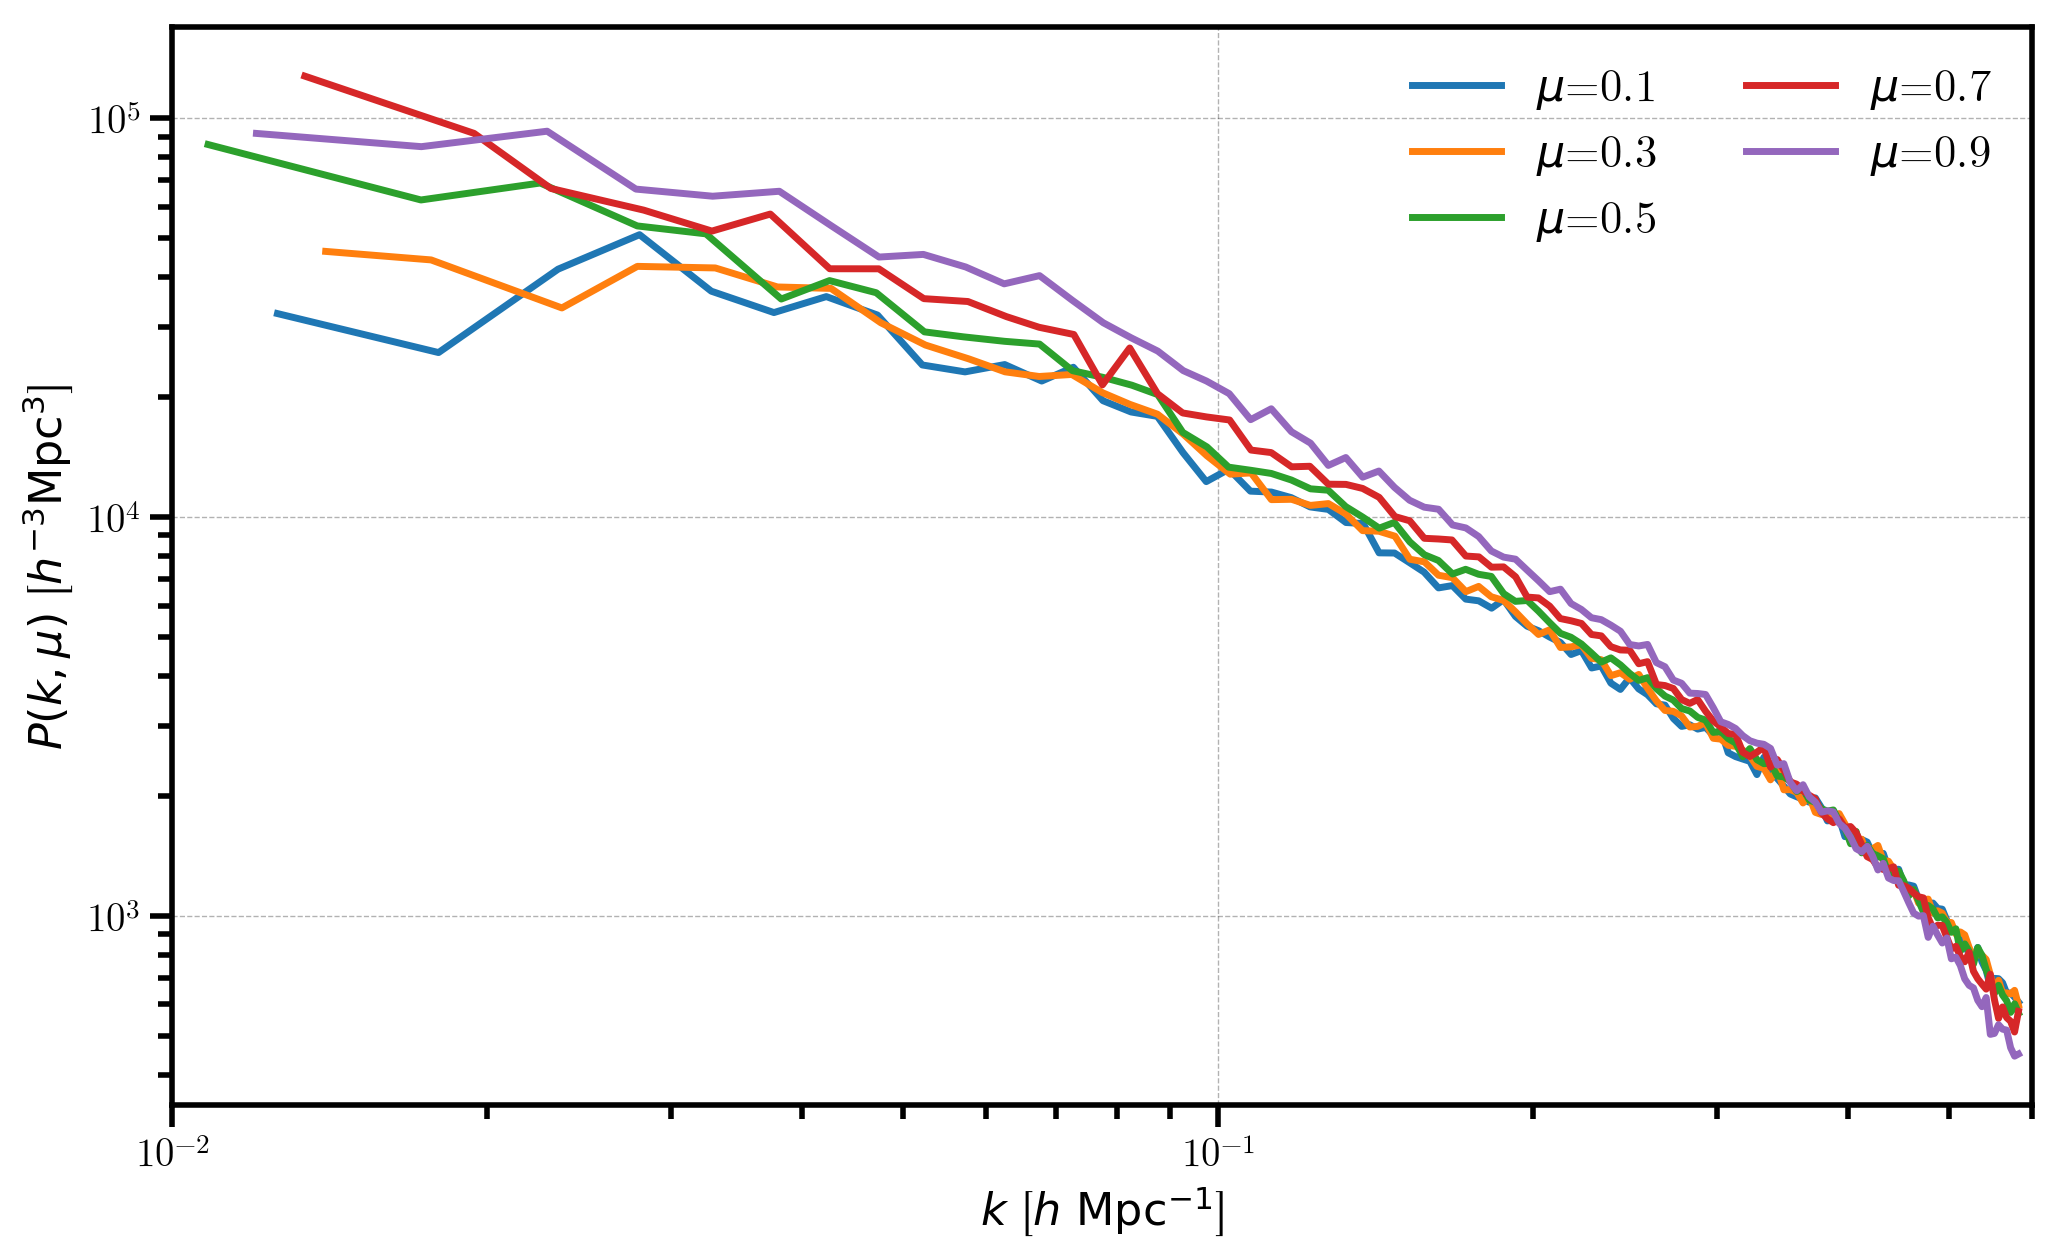

In [14]:
# plot each mu bin
for i in range(Pkmu.shape[1]):
    Pk = Pkmu[:,i] # select the ith mu bin
    label = r'$\mu$=%.1f' % (Pkmu.coords['mu'][i])
    plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)

# format the axes
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

Now, we specify the line-of-sight as the ``x`` axis and again compute the 2D power. 

In [15]:
r = FFTPower(mesh, mode='2d', dk=0.005, kmin=0.01, Nmu=5, los=[1,0,0])
Pkmu = r.power

[ 000018.03 ]   0: 10-30 20:44  CatalogMesh     INFO     painted 787121 out of 787121 objects to mesh


[ 000018.03 ]   0: 10-30 20:44  CatalogMesh     INFO     mean particles per cell is 0.0469161


[ 000018.03 ]   0: 10-30 20:44  CatalogMesh     INFO     sum is 787120 


[ 000018.03 ]   0: 10-30 20:44  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000018.45 ]   0: 10-30 20:44  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


Again we plot the 2D power for each of the $\mu$ bins, but now that $\mu$ is not defined along the same axis as the redshift-space distortions, we measure isotropic power as a function of $\mu$. 

(0.01, 0.6)

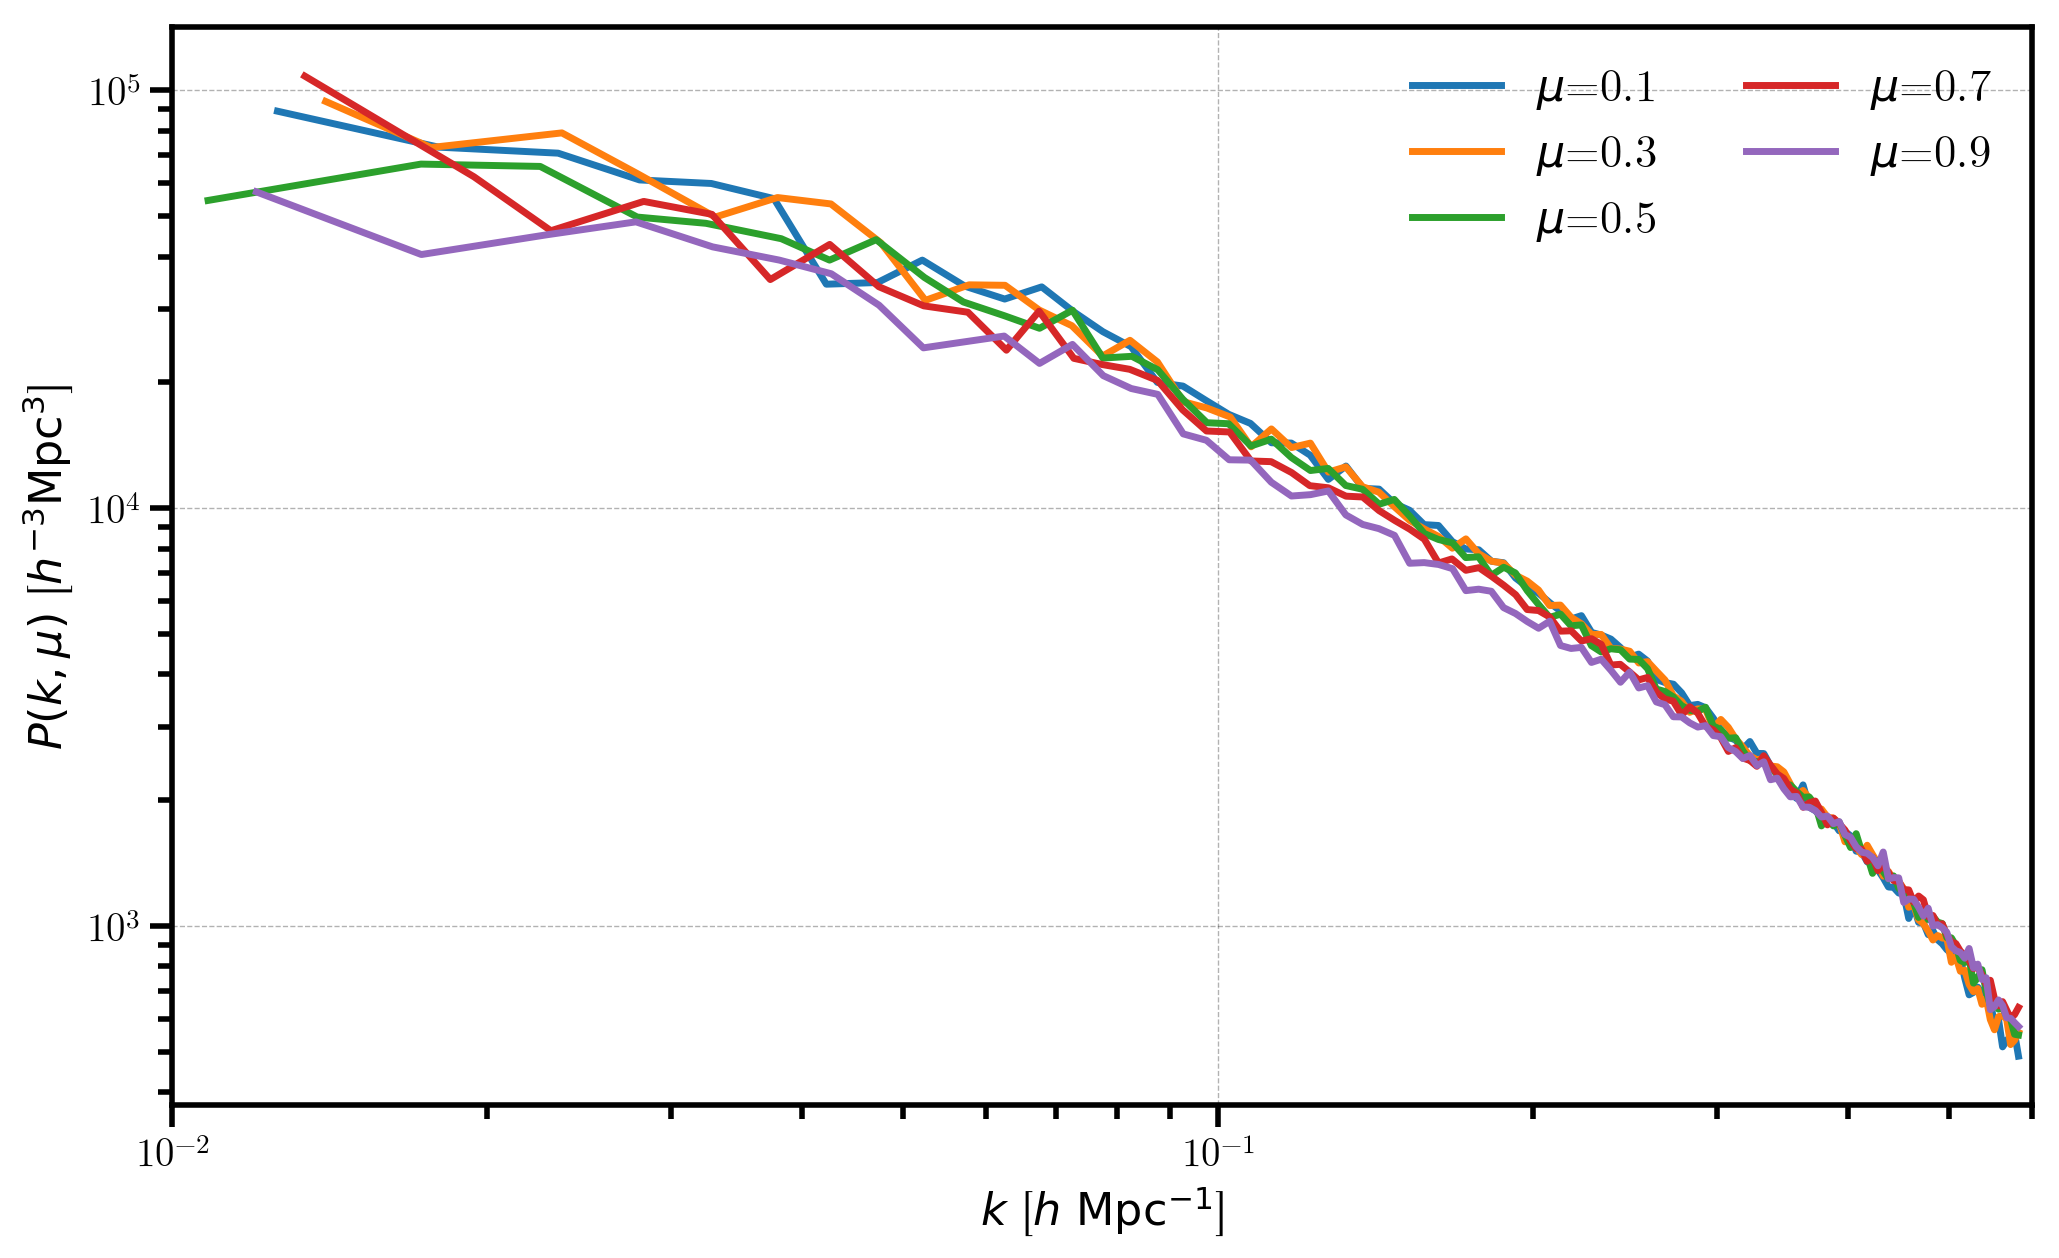

In [16]:
# plot each mu bin
for i in range(Pkmu.shape[1]):
    Pk = Pkmu[:,i] # select the ith mu bin
    label = r'$\mu$=%.1f' % (Pkmu.coords['mu'][i])
    plt.loglog(Pk['k'], Pk['power'].real - Pk.attrs['shotnoise'], label=label)

# format the axes
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k, \mu)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

## Computing the Multipoles, $P_\ell(k)$

In this section, we also measure the power spectrum multipoles, $P_\ell$, which projects the 2D power on to a basis defined by Legendre weights. The desired multipole numbers $\ell$ should be specified as the ``poles`` keyword.

In [17]:
# compute the 2D power AND ell=0,2,4 multipoles
r = FFTPower(mesh, mode='2d', dk=0.005, kmin=0.01, Nmu=5, los=[0,0,1], poles=[0,2,4])

[ 000021.70 ]   0: 10-30 20:44  CatalogMesh     INFO     painted 787121 out of 787121 objects to mesh


[ 000021.70 ]   0: 10-30 20:44  CatalogMesh     INFO     mean particles per cell is 0.0469161


[ 000021.70 ]   0: 10-30 20:44  CatalogMesh     INFO     sum is 787120 


[ 000021.70 ]   0: 10-30 20:44  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000022.04 ]   0: 10-30 20:44  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


Now, there is an additional attribute ``poles`` which stores the $P_\ell(k)$ result.

In [18]:
poles = r.poles
print(poles)
print("variables = ", poles.variables)

<BinnedStatistic: dims: (k: 115), variables: 5 total>
variables =  ['k', 'power_0', 'power_2', 'power_4', 'modes']


We plot each multipole, subtracting the shot noise only from the monopole $P_0$. The multipoles are stored using the variable names "power_0", "power_2", etc for $\ell=0,2,$ etc.

(0.01, 0.6)

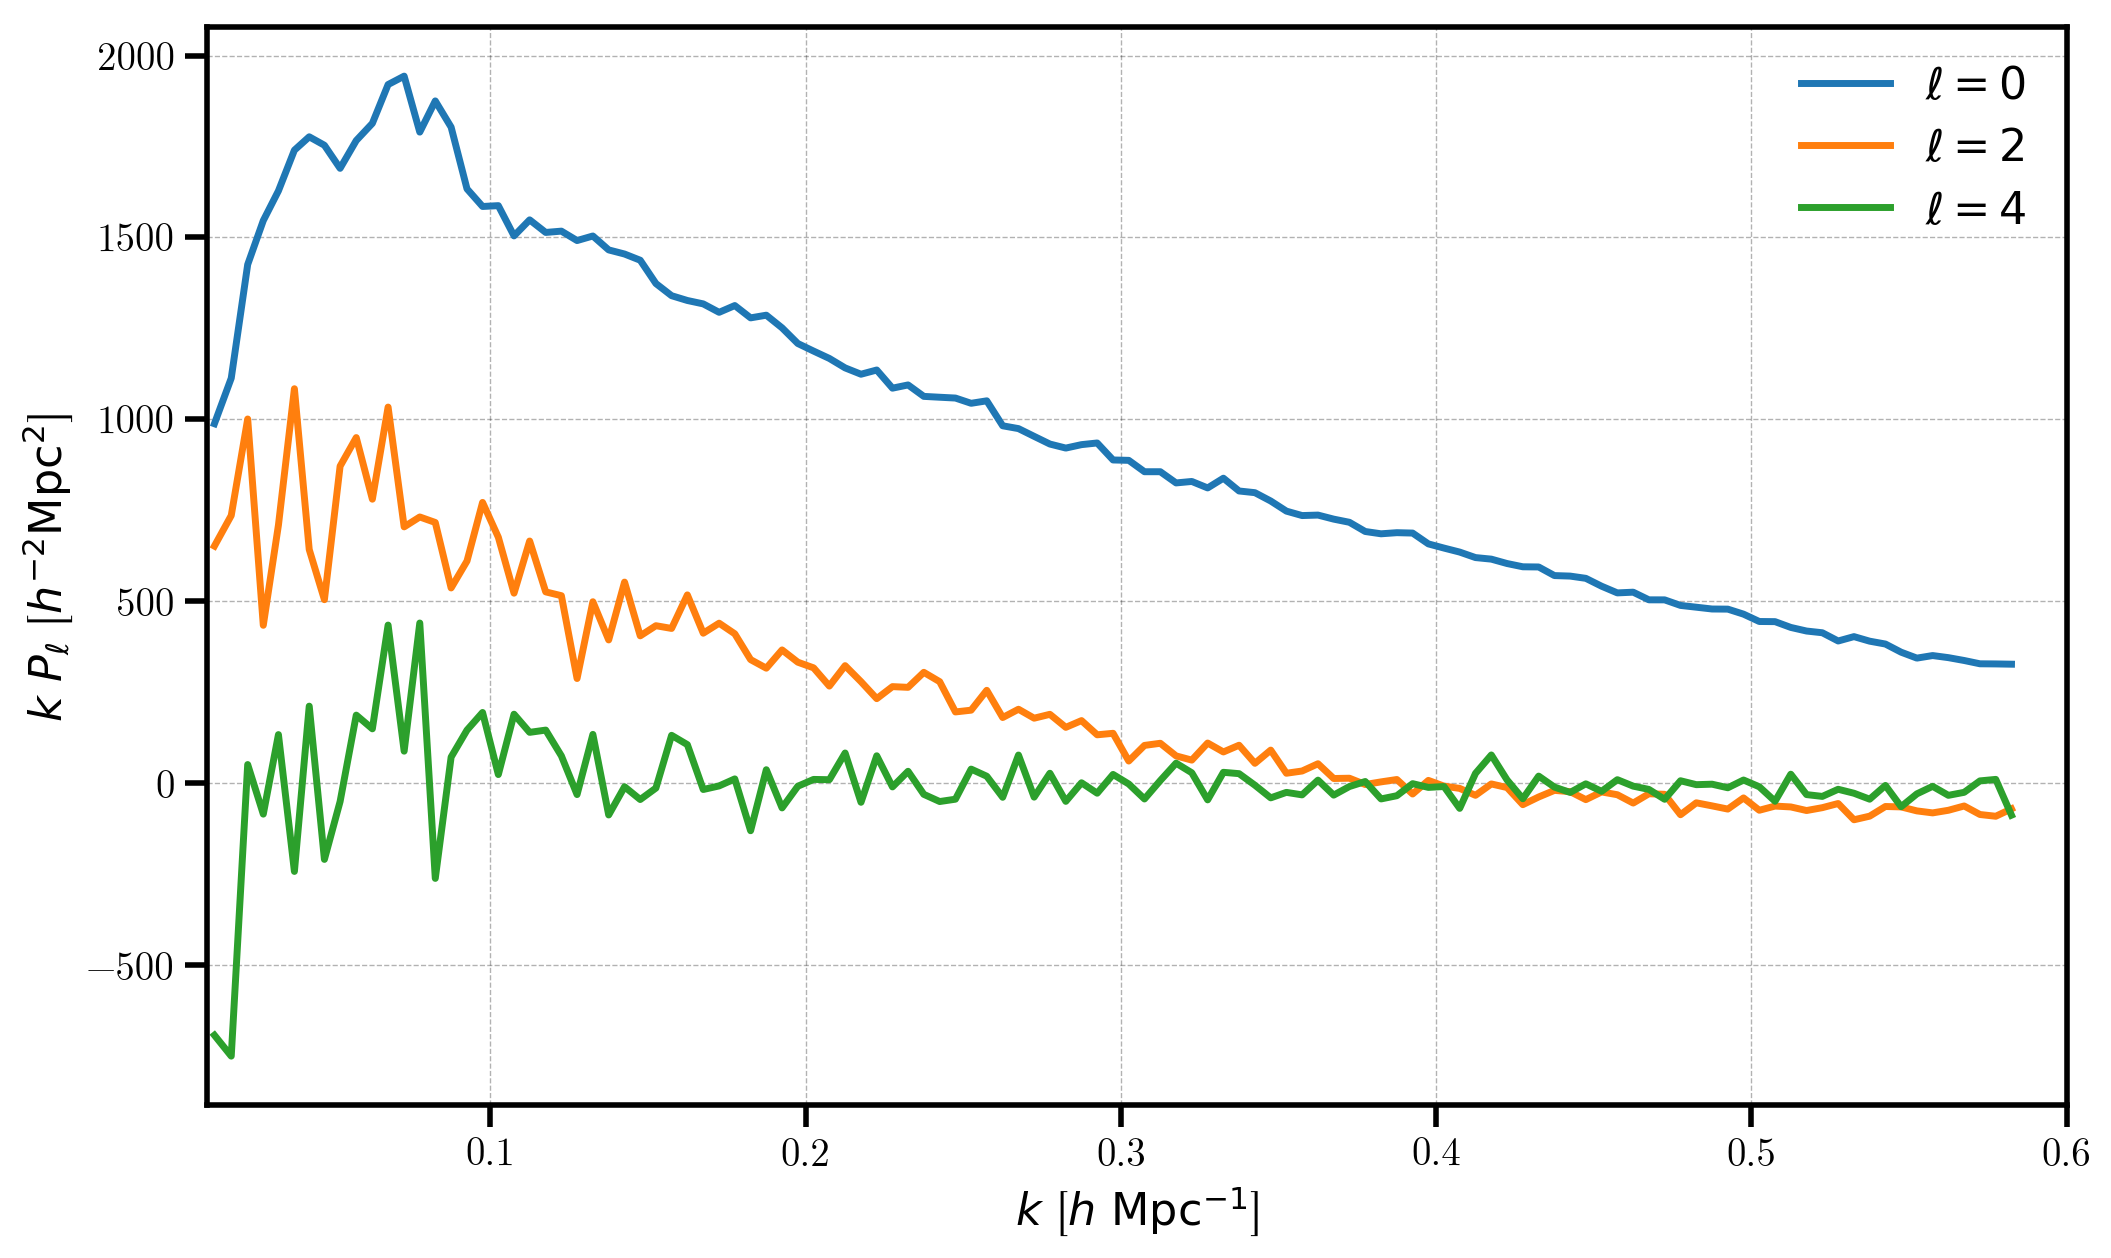

In [19]:
for ell in [0, 2, 4]:
    label = r'$\ell=%d$' % (ell)
    P = poles['power_%d' %ell].real
    if ell == 0: P = P - poles.attrs['shotnoise']
    plt.plot(poles['k'], poles['k'] * P, label=label)

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$k \ P_\ell$ [$h^{-2} \mathrm{Mpc}^2$]")
plt.xlim(0.01, 0.6)